In [20]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

In [26]:
from tensorflow.contrib.tensorboard.plugins import projector
from tensorflow.examples.tutorials.mnist import input_data

LOG_DIR = './visualize'
NAME_TO_VISUALIZE_VARIABLE = 'mnistembedding'
TO_EMBED_COUNT = 500

path_for_mnist_sprites = os.path.join(LOG_DIR, 'mnistdigits.png')
path_for_mnist_metadata =  os.path.join(LOG_DIR,'metadata.tsv')

In [6]:
#what to visualize
mnist = input_data.read_data_sets('MNIST_data/', one_hot=False)
batch_xs, batch_ys = mnist.train.next_batch(TO_EMBED_COUNT)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


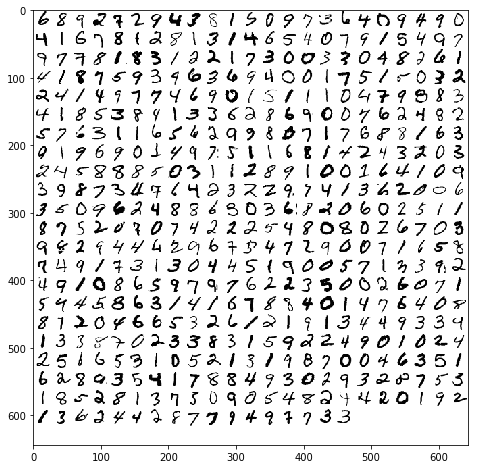

In [39]:
#create sprite image
def create_sprite_image(images):
    """Returns a sprite image consisting of images passed as argument. Images should be count x width x height"""
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    
    
    spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))
    
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                spriteimage[i * img_h:(i + 1) * img_h,
                  j * img_w:(j + 1) * img_w] = this_img
    
    return spriteimage

def vector_to_matrix_mnist(mnist_digits):
    """Reshapes normal mnist digit (batch,28*28) to matrix (batch,28,28)"""
    return np.reshape(mnist_digits,(-1,28,28))

def invert_grayscale(mnist_digits):
    """ Makes black white, and white black """
    return 1-mnist_digits

to_visualize = batch_xs
to_visualize = vector_to_matrix_mnist(to_visualize)
to_visualize = invert_grayscale(to_visualize)

sprite_image = create_sprite_image(to_visualize)

plt.imsave(path_for_mnist_sprites, sprite_image, cmap='gray')
plt.imshow(sprite_image, cmap='gray')

In [40]:
#create metadata info

with open(path_for_mnist_metadata, 'w') as f:
    f.write("Index\tLabel\n")
    for index, label in enumerate(batch_ys):
        f.write("%d\t%d\n" % (index, label))

In [41]:
embedding_var = tf.Variable(batch_xs, name=NAME_TO_VISUALIZE_VARIABLE)
summary_writer = tf.summary.FileWriter(LOG_DIR)

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

#metadata
embedding.metadata_path = path_for_mnist_metadata

#sprite
embedding.sprite.image_path = path_for_mnist_sprites
embedding.sprite.single_image_dim.extend([28, 28])

projector.visualize_embeddings(summary_writer, config)

In [42]:
sess = get_session()

In [43]:
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"), 1)

'./visualize/model.ckpt-1'

In [24]:
!tensorboard --logdir=LOG_DIR

Starting TensorBoard b'41' on port 6006
(You can navigate to http://127.0.1.1:6006)
^C
Traceback (most recent call last):
  File "/home/nipun/cs231n/assignment3/.env/lib/python3.5/site-packages/tensorboard/tensorboard.runfiles/org_tensorflow/tensorflow/tensorboard/tensorboard.py", line 155, in <module>
    app.run()
  File "/home/nipun/cs231n/assignment3/.env/lib/python3.5/site-packages/tensorboard/tensorboard.runfiles/org_tensorflow/tensorflow/python/platform/app.py", line 44, in run
    _sys.exit(main(_sys.argv[:1] + flags_passthrough))
  File "/home/nipun/cs231n/assignment3/.env/lib/python3.5/site-packages/tensorboard/tensorboard.runfiles/org_tensorflow/tensorflow/tensorboard/tensorboard.py", line 151, in main
    tb_server.serve_forever()
  File "/usr/lib/python3.5/socketserver.py", line 232, in serve_forever
    ready = selector.select(poll_interval)
  File "/usr/lib/python3.5/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
KeyboardInterrupt
